# News Group Classification

In this project, we aim to build a **text classification model** that can automatically categorize news articles into their respective topics. This involves applying **Natural Language Processing (NLP)** techniques and training a machine learning model on labeled news data.


# Importing Libraries

In [141]:
import pandas as pd
import contractions
from matplotlib import pyplot as plt
import numpy as np
import re
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.utils.parallel import Parallel, delayed
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import warnings

# import nltk
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('stopwords')

# Dataset Overview

Our dataset consists of news articles with the following columns:

- **category**: The target label indicating the topic of the article (e.g., sports, tech, politics, etc.).
- **filename**: The file name or path associated with each article.
- **content**: The full text of the news article, which will serve as our main input for training the classification model.

We'll use the **`content`** column as the input feature for NLP processing, and the **`category`** column as the target for model training.


In [ ]:
data = pd.read_parquet("news_data.parquet",engine='pyarrow')

In [12]:
# data.to_csv('news_data.csv', index=False)

In [13]:
print(data.head())

      category filename                                            content
0  alt.atheism    49960  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49...
1  alt.atheism    51060  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...
2  alt.atheism    51119  Newsgroups: alt.atheism\nPath: cantaloupe.srv....
3  alt.atheism    51120  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...
4  alt.atheism    51121  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...


In [14]:
print(data.shape)               # Rows and columns

(19997, 3)


In [15]:
print(data['category'].value_counts())  # How many articles per category

category
alt.atheism                 1000
comp.graphics               1000
talk.politics.misc          1000
talk.politics.mideast       1000
talk.politics.guns          1000
sci.space                   1000
sci.med                     1000
sci.electronics             1000
sci.crypt                   1000
rec.sport.hockey            1000
rec.sport.baseball          1000
rec.motorcycles             1000
rec.autos                   1000
misc.forsale                1000
comp.windows.x              1000
comp.sys.mac.hardware       1000
comp.sys.ibm.pc.hardware    1000
comp.os.ms-windows.misc     1000
talk.religion.misc          1000
soc.religion.christian       997
Name: count, dtype: int64


In [16]:
print(data['content'][0])       # View a sample article

Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49960 alt.atheism.moderated:713 news.answers:7054 alt.answers:126
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!magnus.acs.ohio-state.edu!usenet.ins.cwru.edu!agate!spool.mu.edu!uunet!pipex!ibmpcug!mantis!mathew
From: mathew <mathew@mantis.co.uk>
Newsgroups: alt.atheism,alt.atheism.moderated,news.answers,alt.answers
Subject: Alt.Atheism FAQ: Atheist Resources
Summary: Books, addresses, music -- anything related to atheism
Keywords: FAQ, atheism, books, music, fiction, addresses, contacts
Message-ID: <19930329115719@mantis.co.uk>
Date: Mon, 29 Mar 1993 11:57:19 GMT
Expires: Thu, 29 Apr 1993 11:57:19 GMT
Followup-To: alt.atheism
Distribution: world
Organization: Mantis Consultants, Cambridge. UK.
Approved: news-answers-request@mit.edu
Supersedes: <19930301143317@mantis.co.uk>
Lines: 290

Archive-name: atheism/resources
Alt-atheism-archive-name: resources
Last-modified: 11 December

In [17]:
news_content = data['content']
news_labels = data['category']

# Preprocessing

## Clean Raw Input Data

To ensure our text data is ready for machine learning, we apply the following preprocessing steps:

- **Expand Contractions**  
  Convert common contractions to their full form for consistency.  
  _Examples:_
  - `"don't"` → `"do not"`  
  - `"it's"` → `"it is"`

- **Lowercase the Text**  
  Normalize all text to lowercase to reduce vocabulary size and avoid case-sensitive duplicates.

- **Remove Metadata**  
  Strip away unnecessary headers, footers, and email signatures that do not contribute to the actual content.

- **️Remove Numbers and Punctuation**  
  These elements often add noise and are usually not meaningful in text classification tasks.

- **Remove Extra Whitespace**  
  Clean up unnecessary spaces, tabs, and newline characters to maintain uniformity in the text.


In [18]:
news_content = news_content.apply(lambda x: contractions.fix(x)) # expand contractions
news_content  = news_content.str.lower()

In [19]:
def clean_article(text):
    # Remove headers and footers (common email/news metadata)
    text = re.sub(r"(?s)^.*?Lines: \d+\s+", "", text)
    text = re.sub(r"(?s)^.*?(?=Archive-name:)", "", text)
    text = re.sub(r"(?s)^\s*From:.*?\n", "", text)
    text = re.sub(r"(?s)^.*?Subject:.*?\n", "", text)
    text = re.sub(r"(?s)^.*?Path:.*?\n", "", text)
    text = re.sub(r"(?s)^.*?Newsgroups:.*?\n", "", text)
    text = re.sub(r"(?s)^.*?Message-ID:.*?\n", "", text)
    text = re.sub(r"(?s)^.*?Organization:.*?\n", "", text)

    # Remove email signatures (e.g., lines starting with '--')
    text = re.sub(r"--\s*\n.*", "", text, flags=re.DOTALL)

    # Remove numbers and punctuation
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    # Remove extra whitespace (tabs, newlines, multiple spaces)
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [20]:
news_content = news_content.apply(clean_article)

In [21]:
#news_content[0] # sample output to ensure cleaning was applied


# Tokenization and stopwords removal

- **Tokenize Text**    
  Break each cleaned text into individual words (tokens) using NLTK's word_tokenize. This enables more granular analysis and further NLP processing.
  
  _Examples:_
  - `"the quick brown fox"` → `["the", "quick", "brown", "fox"]`

- **Remove Stopwords**
  Eliminate common English stopwords (e.g., "the", "is", "and") using NLTK’s predefined list. These words typically carry less semantic meaning and can introduce noise in text classification tasks.

  _Examples:_
  - `["the", "quick", "brown", "fox"]` → `["quick", "brown", "fox"]`

In [22]:
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# Apply to the series
news_tokens = news_content.apply(tokenize_and_remove_stopwords)


# Lemmatization

Reduce inflected or variant word forms to their **dictionary headword** form.

Examples:

• am, are, is → be

• car, cars, car's, cars’ → car

In [23]:
print(news_tokens)

0        [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...
1        [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...
2        [newsgroups, alt, atheism, path, cantaloupe, s...
3        [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...
4        [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...
                               ...                        
19992    [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...
19993    [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...
19994    [xref, cantaloupe, srv, cs, cmu, edu, talk, re...
19995    [xref, cantaloupe, srv, cs, cmu, edu, talk, re...
19996    [xref, cantaloupe, srv, cs, cmu, edu, talk, ab...
Name: content, Length: 19997, dtype: object


In [24]:
# # Convert Series to DataFrame
# df = news_tokens.to_frame(name = 'tokens')
#
# # POS tag conversion
# def get_wordnet_pos(tag):
#     if tag.startswith('J'):
#         return wordnet.ADJ
#     elif tag.startswith('V'):
#         return wordnet.VERB
#     elif tag.startswith('N'):
#         return wordnet.NOUN
#     elif tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN
#
# lemmatizer = WordNetLemmatizer()
#
# # Lemmatize one row of tokens
# def lemmatize_tokens(tokens):
#     tagged = pos_tag(tokens)
#     return [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged]
#
# # Apply to all rows
# df['lemmatized'] = df['tokens'].apply(lemmatize_tokens)
#
# # Show result
# print(df[['tokens', 'lemmatized']])


In [25]:
# Load spaCy model (only run once)
nlp = spacy.load("en_core_web_sm")

# Convert Series to DataFrame
df = news_tokens.to_frame(name = 'tokens')

# Lemmatize using spaCy
def spacy_lemmatize(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

df['lemmatized'] = df['tokens'].apply(spacy_lemmatize)
print(df[['tokens', 'lemmatized']])

                                                  tokens  \
0      [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...   
1      [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...   
2      [newsgroups, alt, atheism, path, cantaloupe, s...   
3      [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...   
4      [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...   
...                                                  ...   
19992  [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...   
19993  [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...   
19994  [xref, cantaloupe, srv, cs, cmu, edu, talk, re...   
19995  [xref, cantaloupe, srv, cs, cmu, edu, talk, re...   
19996  [xref, cantaloupe, srv, cs, cmu, edu, talk, ab...   

                                              lemmatized  
0      [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...  
1      [xref, cantaloupe, srv, cs, cmu, edu, alt, ath...  
2      [newsgroup, alt, atheism, path, cantaloupe, sr...  
3      [xref, cantaloupe, srv, cs, cmu, edu

In [26]:
news_lemmas = df['lemmatized']


## TF–IDF Vectorization

Transform raw text data into numerical features.TF–IDF captures the importance of words across documents by balancing their frequency within a document.

 - Reconstruct Tokenized Text

In [27]:
cleaned_text = news_lemmas.apply(lambda tokens: " ".join(tokens))

- Initialize the vectorizer

In [28]:
vectorizer = TfidfVectorizer(
    # ignore very rare words
    min_df=5,
    # ignore very common words
    max_df=0.8,
    # include unigrams and bigrams -> Unigrams are capture the frequency of individual words,Bigrams capture the relationship between two consecutive words, which can be useful for understanding the context and meaning of words in a sentence.
    ngram_range=(1,2),
)



In [29]:
#vectorizer = TfidfVectorizer()

- transform into a TF–IDF matrix

In [30]:
tfidf_matrix = vectorizer.fit_transform(cleaned_text)


In [31]:
print("TF–IDF matrix shape:", tfidf_matrix.shape)

feature_names = vectorizer.get_feature_names_out()

TF–IDF matrix shape: (19997, 115666)


In [32]:
# Assuming you have the vectorizer object

# Get top 10 important words in this document
sorted_indices = tfidf_matrix[0][0].toarray().argsort()[0][-10:][::-1]
top_words = [(feature_names[i], tfidf_matrix[0][0][0,i]) for i in sorted_indices]

print("Top words in this document:")
for word, score in top_words:
    print(f"{word}: {score:.4f}")

Top words in this document:
atheism: 0.2865
fish: 0.2617
mantis: 0.2209
alt atheism: 0.2017
alt: 0.1957
resource: 0.1601
news answer: 0.1530
atheist: 0.1515
answer: 0.1464
evolution: 0.1388


## Word Embedding using Word2Vec

Convert words into dense, continuous-valued vectors that capture semantic relationships. Unlike TF–IDF, which treats each term independently, Word2Vec learns word representations so that words appearing in similar contexts end up with similar vectors.

How it works: Word2Vec slides a window over each token list and learns to predict a target word from its neighbors (or vice versa).

In [33]:
# # 7. Train Word2Vec model
# w2v_model = Word2Vec(
#     sentences=news_tokens,
#     vector_size=100,  # dimensionality
#     window=5,
#     min_count=5,      # ignore words with freq < 5
#     workers=4,        # Number of CPU cores used
#     seed=42
# )
# w2v_model.save("word2vec.model")

-  Build document embeddings by averaging word vectors

In [34]:
# def document_vector(tokens):
#     vecs = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
#     if not vecs:
#         return np.zeros(w2v_model.vector_size)
#     return np.mean(vecs, axis=0)

In [35]:
# import numpy as np

# embeddings = np.vstack(news_tokens.apply(document_vector).values)
# df_embeddings = pd.DataFrame(
#     embeddings,
#     columns=[f"dim_{i}" for i in range(w2v_model.vector_size)]
# )

In [36]:
# df_embeddings.to_parquet('doc_embeddings.parquet', engine='pyarrow')
# print("Document embeddings saved; shape:", df_embeddings.shape)

# Train-Validation-Test split


Split the dataset into three subsets to enable effective model training, validation, and testing. This ensures unbiased evaluation and prevents overfitting.

 -  Split off test (20%)

In [37]:
X_temp, X_test, y_temp, y_test = train_test_split(
    tfidf_matrix,
    news_labels,
    test_size=0.20,       # 20% → test set
    random_state=42,
    stratify=news_labels
)

- Split the remaining 80% into train (60%) and validation (20%)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,       # 25% of 80% = 20% overall for validation
    random_state=42,
    stratify=y_temp
)

In [39]:
print(f"Train  → X_train: {X_train.shape},  y_train: {y_train.shape}")
print(f"Val    → X_val:   {X_val.shape},    y_val:   {y_val.shape}")
print(f"Test   → X_test:  {X_test.shape},   y_test:  {y_test.shape}")

Train  → X_train: (11997, 115666),  y_train: (11997,)
Val    → X_val:   (4000, 115666),    y_val:   (4000,)
Test   → X_test:  (4000, 115666),   y_test:  (4000,)


# Modeling


## Naive Bayes

* GridSearch on the best hyperparameter values

In [40]:
hyper_parameters_naive = {
    'alpha': [0.01, 0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

naive_model = GridSearchCV(MultinomialNB(), hyper_parameters_naive, cv=5, scoring='accuracy')
naive_model.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0],
                         'fit_prior': [True, False]},
             scoring='accuracy')

* Plot GridSearchCV results using Seaborn's heatmap

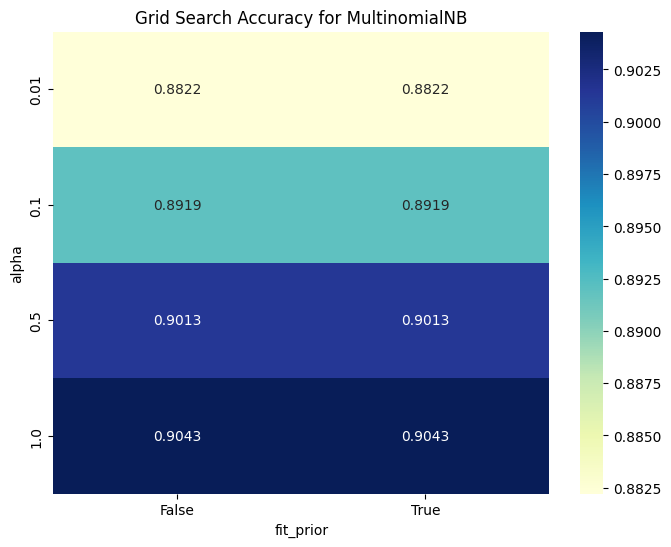

In [41]:
# Convert to DataFrame
results_df = pd.DataFrame(naive_model.cv_results_)

# Create a pivot table for plotting
pivot_table = results_df.pivot(index='param_alpha', columns='param_fit_prior', values='mean_test_score')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Grid Search Accuracy for MultinomialNB")
plt.xlabel("fit_prior")
plt.ylabel("alpha")
plt.show()

* Trial-Error on the best hyperparameter values

In [42]:
# Range of the values in log-space
alpha_values = [0.01, 0.1, 0.5, 1.0]
fit_prior_values = [True, False]

results = []

for alpha in alpha_values:
    for fit_prior in fit_prior_values:
        model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append({
            'alpha': alpha,
            'fit_prior': fit_prior,
            'accuracy': acc
        })

* Plot Trial-Error results using Seaborn's heatmap

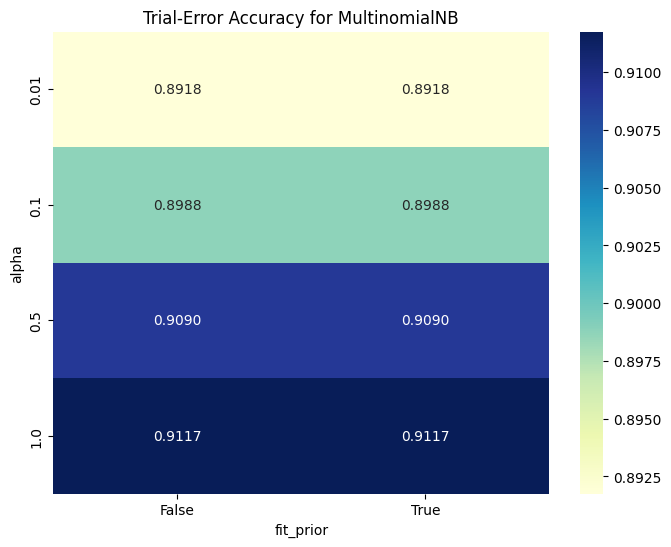

In [43]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Pivot for heatmap format
pivot = results_df.pivot(index='alpha', columns='fit_prior', values='accuracy')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Trial-Error Accuracy for MultinomialNB")
plt.xlabel("fit_prior")
plt.ylabel("alpha")
plt.show()

Looking at the plots we can see that the best hyperparameters are alpha = 1 and any value of fit_prior

* Training model with the best hyperparameters

In [44]:
best_model = MultinomialNB(alpha=1, fit_prior=True)
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred  = best_model.predict(X_test)

* Plotiing confusion matrix using Seaborn's heatmap

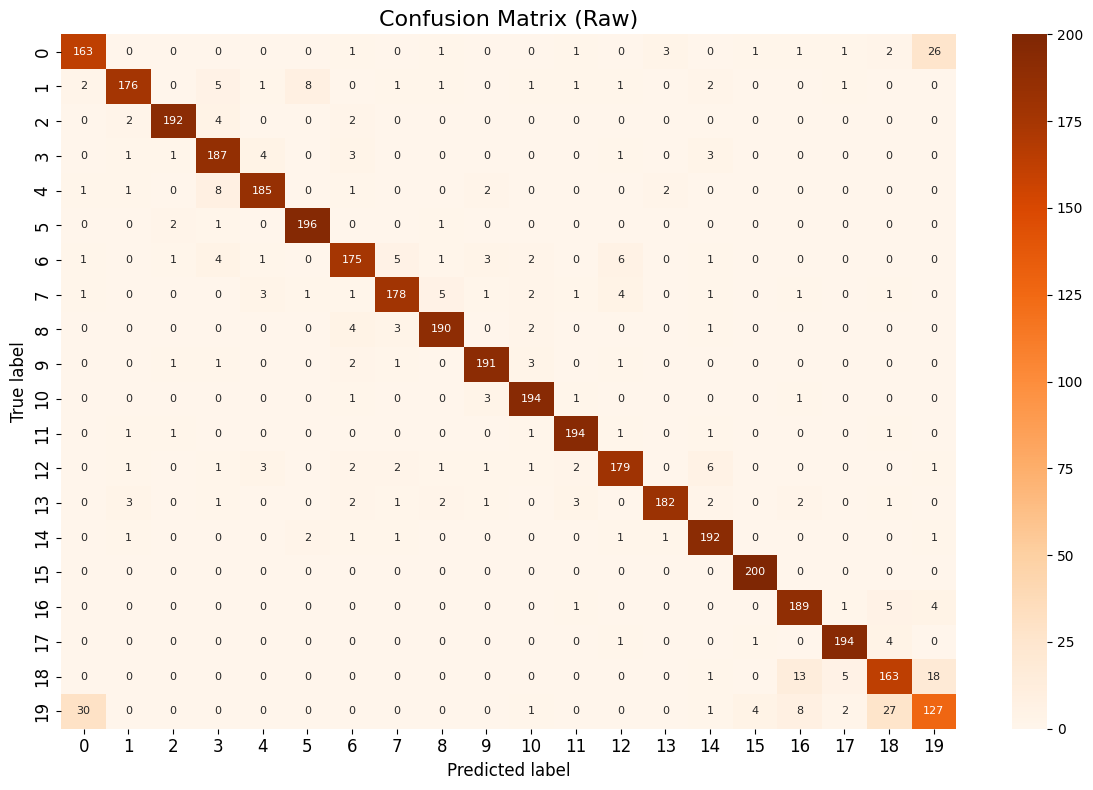

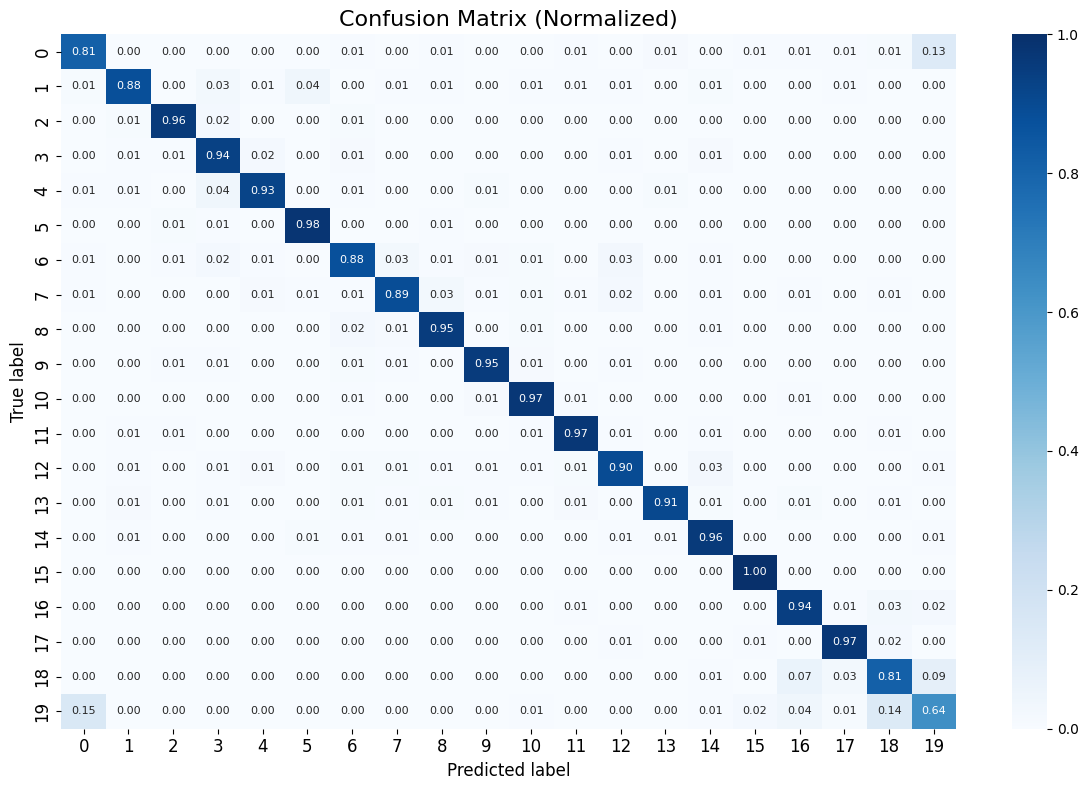

In [45]:
# Raw confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',                    
    cmap='Oranges',
    annot_kws={"size": 8},
    ax=ax
)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
ax.set_title("Confusion Matrix (Raw)", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_norm = confusion_matrix(y_test, y_test_pred, normalize='true')
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    annot_kws={"size": 8},
    ax=ax
)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
ax.set_title("Confusion Matrix (Normalized)", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

* Classification metrics for test and training

In [46]:
rows = []
for split_name, y_true, y_pred in [
    ("Train", y_train, y_train_pred),
    ("Test",  y_test,  y_test_pred)
]:
    rows.append({
        "Split":      split_name,
        "Accuracy":   accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average="macro"),
        "Precision":  precision_score(y_true, y_pred, average="macro"),
        "Recall":     recall_score(y_true, y_pred, average="macro"),
    })

df_metrics = pd.DataFrame(rows).set_index("Split").round(4)
print(df_metrics)

       Accuracy      F1  Precision  Recall
Split                                     
Train    0.9497  0.9494     0.9496  0.9497
Test     0.9118  0.9109     0.9110  0.9118


## Random Forest

* GridSearch on the best hyperparameter values

In [47]:
hyper_parameters_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}

rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
rf_model = GridSearchCV(
    estimator=rf,
    param_grid=hyper_parameters_rf,
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
)

rf_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

* Plot GridSearchCV results using Seaborn's heatmap

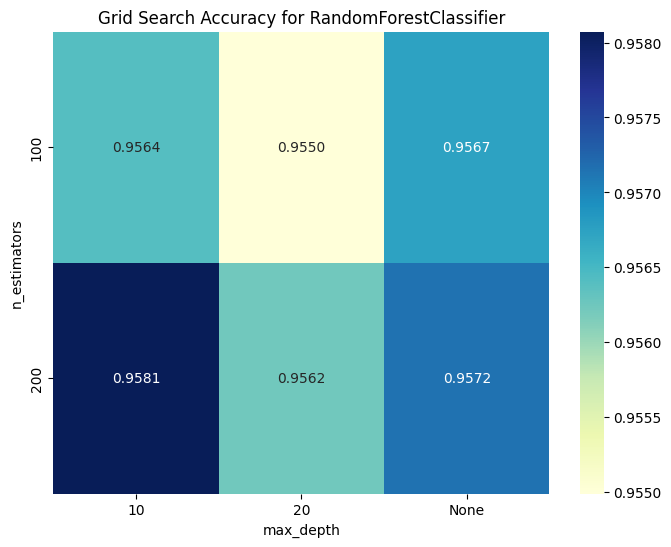

In [48]:
# Convert to DataFrame
results_df = pd.DataFrame(rf_model.cv_results_)
# Deal with none value
results_df['param_max_depth'] = results_df['param_max_depth'].astype(str)

# Create a pivot table for plotting
pivot_table = results_df.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Grid Search Accuracy for RandomForestClassifier")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.show()

* Trial-Error on the best hyperparameter values

In [49]:
# Range of the values in log-space
n_estimators_values = [100, 200]
max_depth_values = [None, 10, 20]

def train_and_score(n_estimator, max_depth, X_train, y_train, X_test, y_test):

    rf = RandomForestClassifier(
        n_estimators=n_estimator, 
        max_depth=max_depth, 
        random_state=42
    )
    rf.fit(X_train, y_train)
    acc = accuracy_score(y_test, rf.predict(X_test))
    return {
        'n_estimators': n_estimator,
        'max_depth':    max_depth,
        'accuracy':     acc
    }

results = Parallel(n_jobs=-1)(
    delayed(train_and_score)(n, d, X_train, y_train, X_test, y_test)
    for n in n_estimators_values
    for d in max_depth_values
)

* Plot Trial-Error results using Seaborn's heatmap

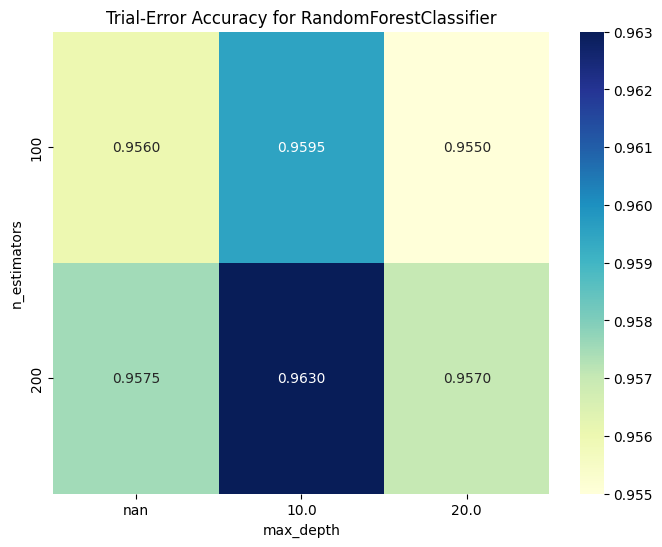

In [50]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Pivot for heatmap format
pivot = results_df.pivot(index='n_estimators', columns='max_depth', values='accuracy')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Trial-Error Accuracy for RandomForestClassifier")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.show()

Looking at the plots we can see that the best hyperparameters are n_estimators = 200 and max_depth = 10

* Training model with the best hyperparameters

In [51]:
best_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred  = best_model.predict(X_test)

* Plotiing confusion matrix using Seaborn's heatmap

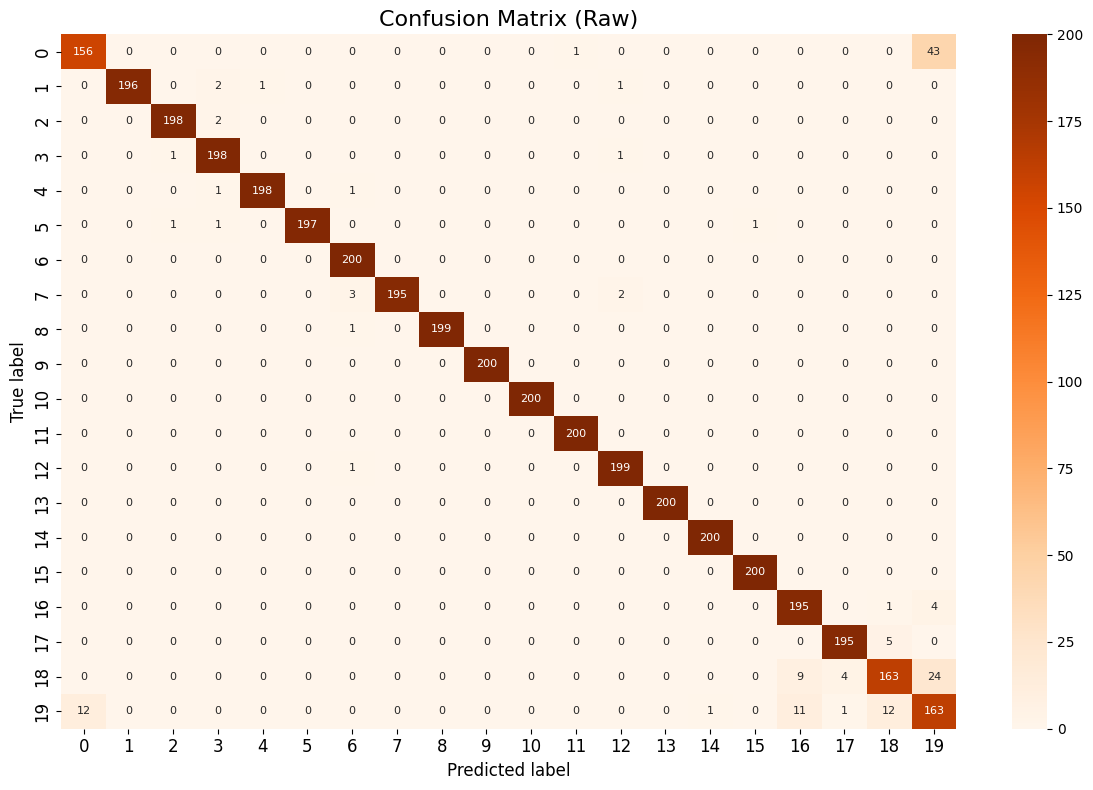

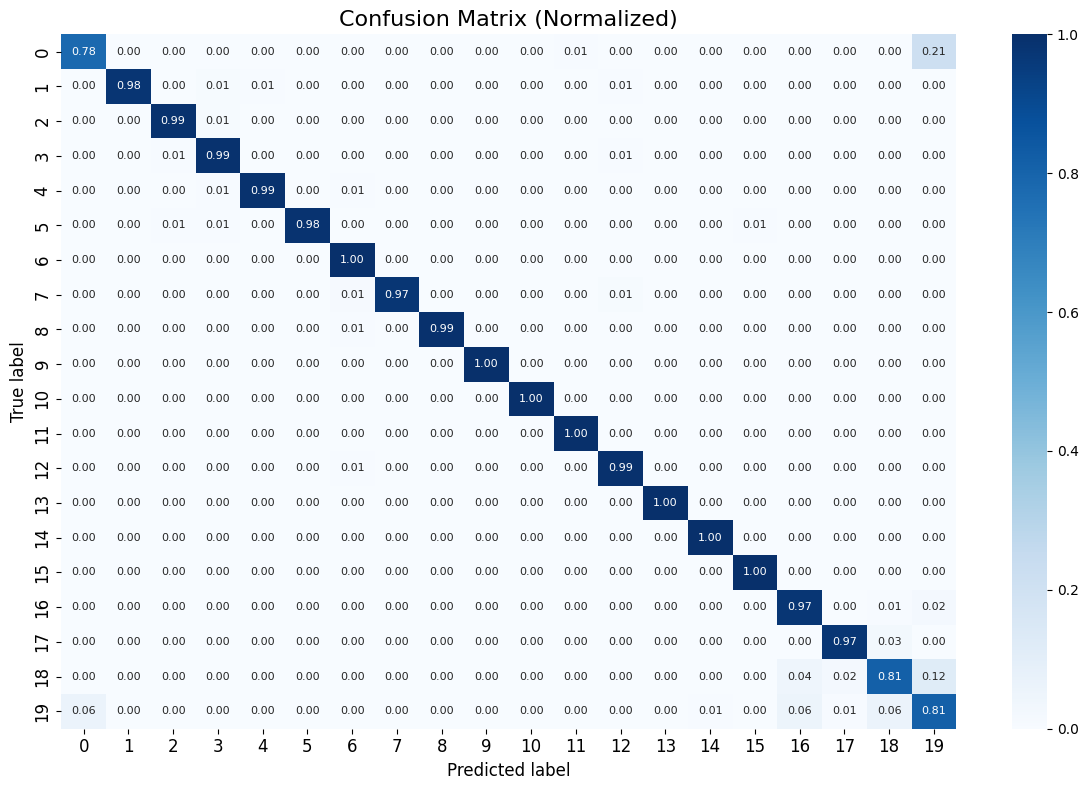

In [52]:
# Raw confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',                    
    cmap='Oranges',
    annot_kws={"size": 8},
    ax=ax
)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
ax.set_title("Confusion Matrix (Raw)", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_norm = confusion_matrix(y_test, y_test_pred, normalize='true')
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    annot_kws={"size": 8},
    ax=ax
)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
ax.set_title("Confusion Matrix (Normalized)", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

* Classification metrics for test and training

In [53]:
rows = []
for split_name, y_true, y_pred in [
    ("Train", y_train, y_train_pred),
    ("Test",  y_test,  y_test_pred)
]:
    rows.append({
        "Split":      split_name,
        "Accuracy":   accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average="macro"),
        "Precision":  precision_score(y_true, y_pred, average="macro"),
        "Recall":     recall_score(y_true, y_pred, average="macro"),
    })

df_metrics = pd.DataFrame(rows).set_index("Split").round(4)
print(df_metrics)

       Accuracy      F1  Precision  Recall
Split                                     
Train     0.975  0.9751     0.9774   0.975
Test      0.963  0.9632     0.9650   0.963


# SVM

**SVM Hyperparameter Optimization via Grid Search**

In [54]:
# Initialize LinearSVM
svm = LinearSVC(random_state = 42, dual = False)  # dual = False for n_samples > n_features

# Hyperparameter grid
param_svm = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'loss': ['squared_hinge'],
    'class_weight': [None]
}

svm_model = GridSearchCV(
    estimator = svm,
    param_grid = param_svm,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1
)

svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(dual=False, random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'class_weight': [None],
                         'loss': ['squared_hinge'], 'penalty': ['l2']},
             scoring='accuracy')

**Analyze hyperparameter (C / loss) impact on accuracy**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


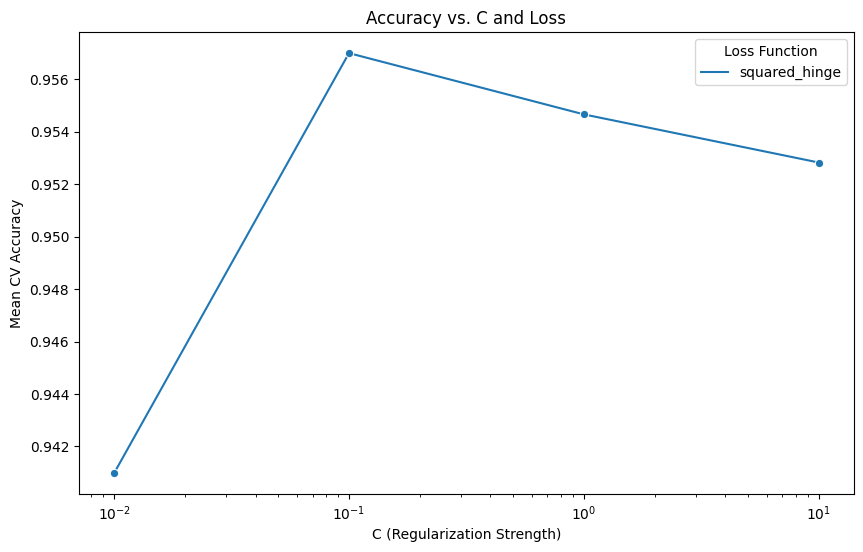

In [55]:
# Convert results to DataFrame
results_df = pd.DataFrame(svm_model.cv_results_)

# Plot accuracy vs. hyperparameters
plt.figure(figsize=(10, 6))
sns.lineplot(
    data = results_df,
    x = 'param_C',
    y = 'mean_test_score',
    hue = 'param_loss',
    marker = 'o'
)
plt.xscale('log')  # Log-scale for C (common in SVM)
plt.title("Accuracy vs. C and Loss")
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Mean CV Accuracy")
plt.legend(title="Loss Function")
plt.show()

**Make predictions with the best SVM model**

In [56]:
# Predict with best model
best_model = svm_model.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

**Confusion Matrix**

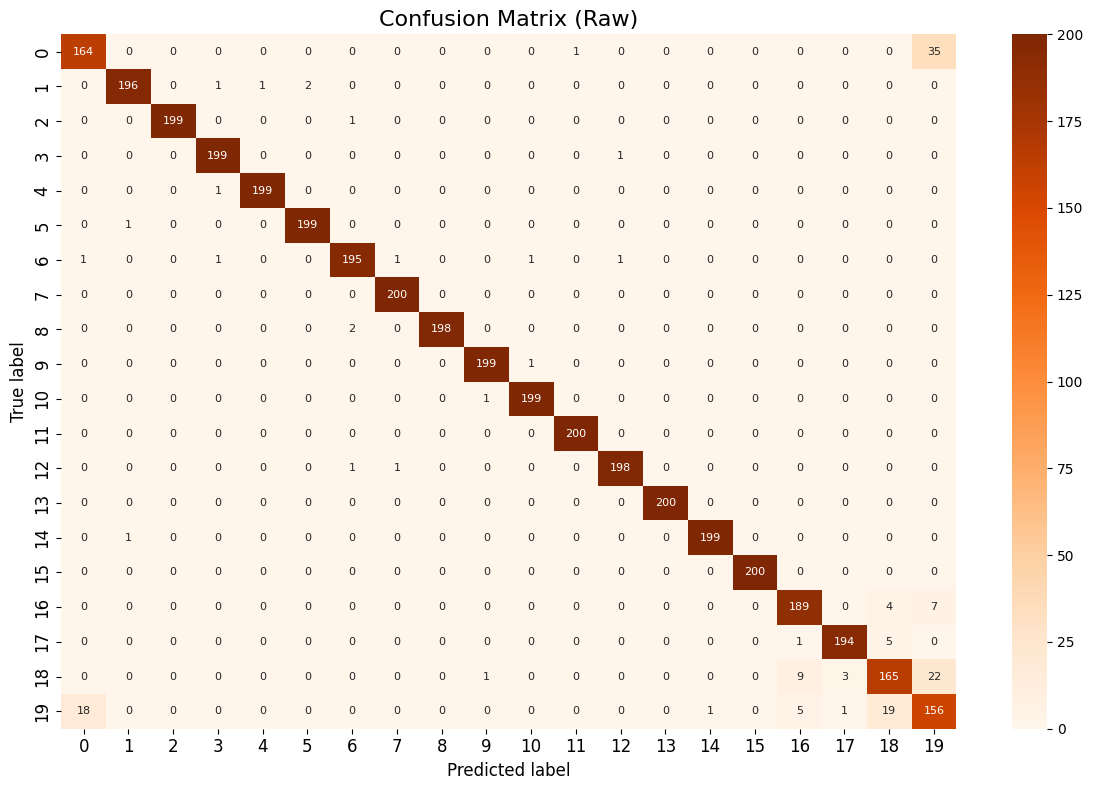

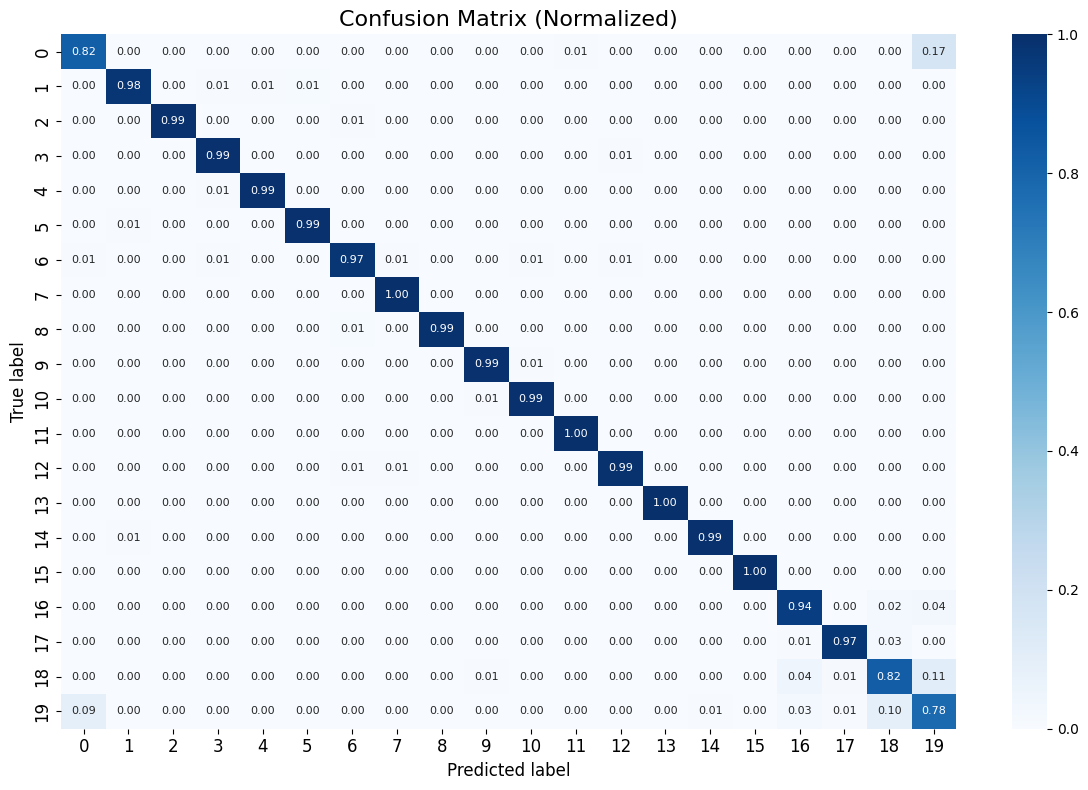

In [57]:
# Non-Normalized (Raw) confusion matrix
# Absolute number of predictions
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize = (12, 8))
sns.heatmap(
    cm,
    annot = True,
    fmt = 'd',
    cmap = 'Oranges',
    annot_kws = {"size": 8},
    ax = ax
)
ax.set_xlabel("Predicted label", fontsize = 12)
ax.set_ylabel("True label", fontsize = 12)
ax.set_title("Confusion Matrix (Raw)", fontsize = 16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
# Percentage of predictions per true class
cm_norm = confusion_matrix(y_test, y_test_pred, normalize = 'true')
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    cm_norm,
    annot = True,
    fmt = '.2f',
    cmap = 'Blues',
    annot_kws = {"size": 8},
    ax = ax
)
ax.set_xlabel("Predicted label", fontsize = 12)
ax.set_ylabel("True label", fontsize = 12)
ax.set_title("Confusion Matrix (Normalized)", fontsize = 16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.tight_layout()
plt.show()

**Compute performance metrics for train/test splits**

In [58]:
rows = []
for split_name, y_true, y_pred in [
    ("Train", y_train, y_train_pred),
    ("Test",  y_test,  y_test_pred)
]:
    rows.append({
        "Split":      split_name,
        "Accuracy":   accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average="macro"),
        "Precision":  precision_score(y_true, y_pred, average="macro"),
        "Recall":     recall_score(y_true, y_pred, average="macro"),
    })

df_metrics = pd.DataFrame(rows).set_index("Split").round(4)
print(df_metrics)

       Accuracy      F1  Precision  Recall
Split                                     
Train    0.9741  0.9741     0.9749  0.9741
Test     0.9620  0.9622     0.9628  0.9620


# KNN

**KNN Hyperparameter Optimization via Grid Search**

In [134]:
svd = TruncatedSVD(random_state=162)
norm = Normalizer()
knn = KNeighborsClassifier()
pipe = Pipeline([('svd', svd), ('norm', norm), ('knn', knn)])

param_grid = {
    'svd__n_components': [50, 100, 150],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights':     ['uniform','distance'],
    'knn__p':           [1,2],
}

knn_model = GridSearchCV(
        estimator = pipe,
        param_grid=param_grid,
        cv = 3,
        scoring='accuracy',
        n_jobs=-1
    )
knn_model.fit(X_train, y_train)
print("Best params:", knn_model.best_params_)

Best params: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance', 'svd__n_components': 100}


**Analyze hyperparameters impact on accuracy**

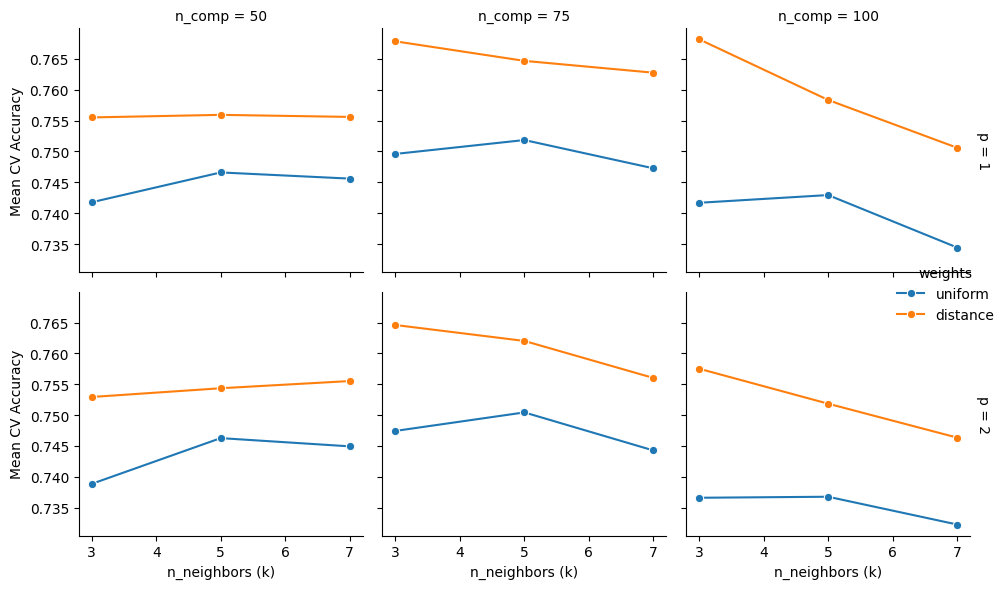

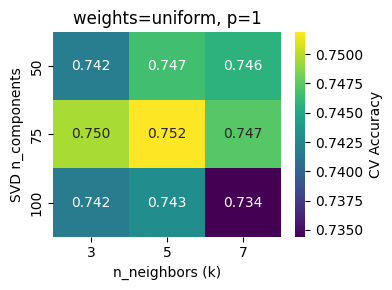

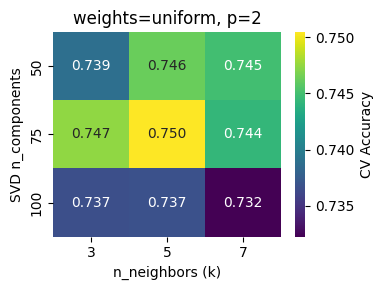

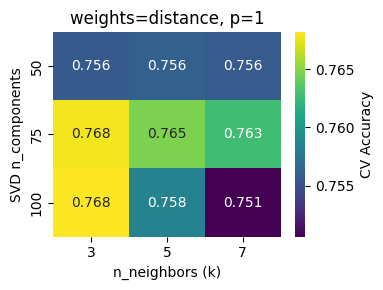

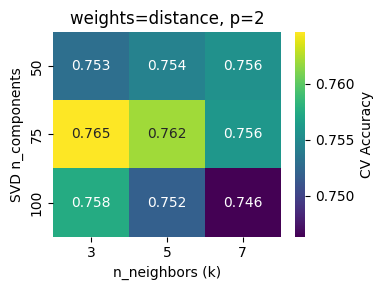

In [143]:
warnings.filterwarnings(
    "ignore",
    message=".*use_inf_as_na option is deprecated.*",
    category=FutureWarning
)

# Convert results to DataFrame
results_knn = pd.DataFrame(knn_model.cv_results_)

# Rename & convert datatypes
results_knn = results_knn.rename(columns={
    'param_svd__n_components': 'n_comp',
    'param_knn__n_neighbors':  'k',
    'param_knn__weights':      'weights',
    'param_knn__p':            'p'
})

results_knn['n_comp'] = results_knn['n_comp'].astype(int)
results_knn['k'] = results_knn['k'].astype(int)
results_knn['p'] = results_knn['p'].astype(int)

# g = sns.FacetGrid(
#     results_knn,
#     col='n_comp',
#     hue='weights',
#     row='p',
#     margin_titles=True,
#     height=3,
#     sharey=True
# )
# g.map(
#     sns.lineplot, 'k', 'mean_test_score', marker='o', dashes=False
# )
# g.add_legend(title='weights')
# g.set_axis_labels("n_neighbors (k)", "Mean CV Accuracy")
# g.set_titles("SVD dims = {col_name}, p = {row_name}")
# plt.tight_layout()
# plt.show()

# Heatmaps: one per (weights, p)
for w in results_knn['weights'].unique():
    for p_val in results_knn['p'].unique():
        sub = results_knn[(results_knn['weights']==w) & (results_knn['p']==p_val)]
        pivot = sub.pivot_table(
            index='n_comp',
            columns='k',
            values='mean_test_score'
        )
        plt.figure(figsize=(4,3))
        sns.heatmap(
            pivot, annot=True, fmt=".3f", cmap='viridis',
            cbar_kws={'label':'CV Accuracy'}
        )
        plt.title(f"weights={w}, p={p_val}")
        plt.xlabel("n_neighbors (k)")
        plt.ylabel("SVD n_components")
        plt.tight_layout()
        plt.show()

**Make predictions with the best KNN model**

In [136]:
# Predict with best model
best_model = knn_model.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

**Confusion Matrix**

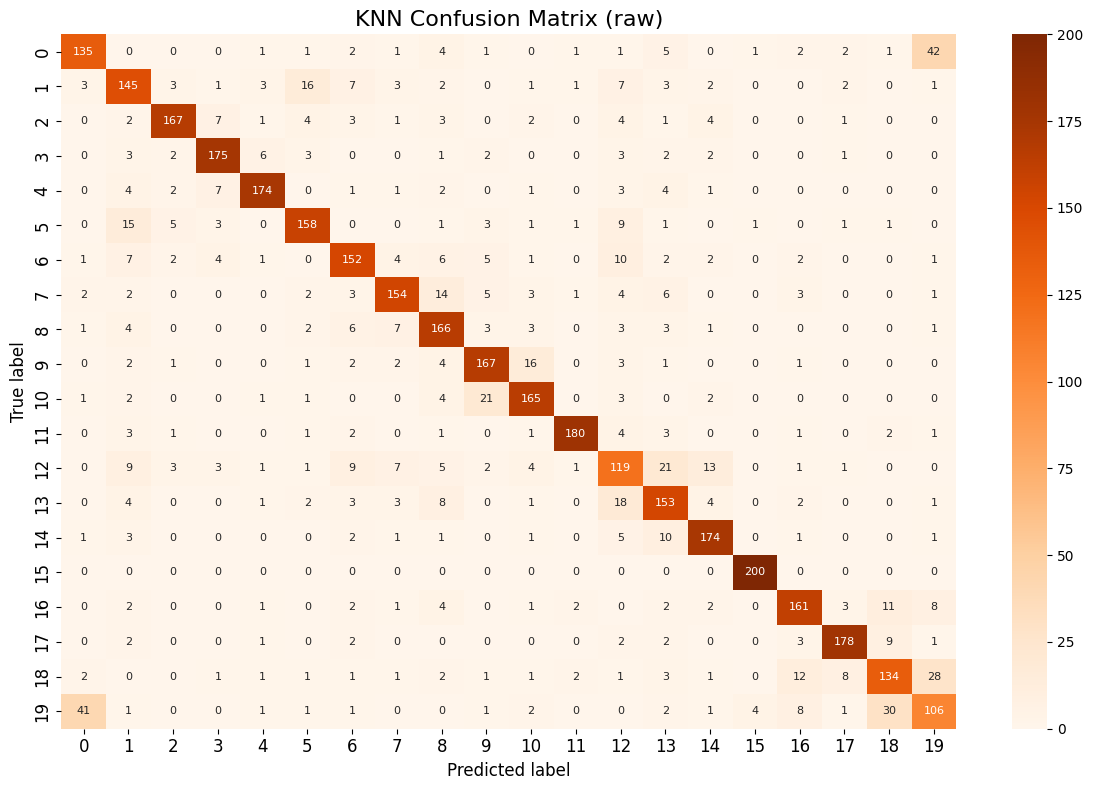

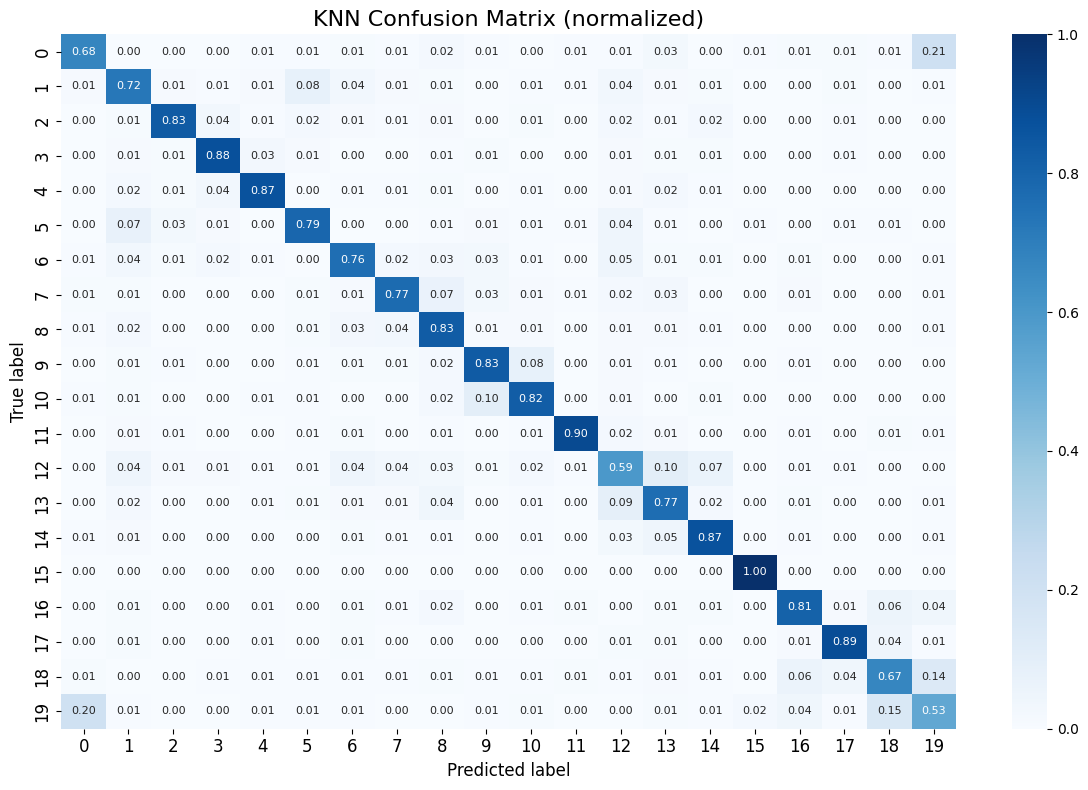

In [137]:
for norm, title, cmap, fmt in [
    (None, "KNN Confusion Matrix (raw)", 'Oranges', 'd'),
    ('true', "KNN Confusion Matrix (normalized)", 'Blues', '.2f')
]:
    cm = confusion_matrix(y_test, y_test_pred, normalize=norm)
    fig, ax = plt.subplots(figsize = (12, 8))
    sns.heatmap(
        cm,
        annot = True,
        fmt = fmt,
        cmap = cmap,
        annot_kws = {"size": 8},
        ax = ax
    )
    plt.title(title, fontsize = 16)
    plt.ylabel("True label", fontsize = 12)
    ax.set_xlabel("Predicted label", fontsize = 12)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    plt.tight_layout()
    plt.show()

**Compute performance metrics for train/test splits**

In [138]:
rows = []
for split_name, y_true, y_pred in [
    ("Train", y_train, y_train_pred),
    ("Test",  y_test,  y_test_pred)
]:
    rows.append({
        "Split":      split_name,
        "Accuracy":   accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "Precision":  precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall":     recall_score(y_true, y_pred, average="macro", zero_division=0),
    })

df_metrics = pd.DataFrame(rows).set_index("Split").round(4)
print(df_metrics)

       Accuracy      F1  Precision  Recall
Split                                     
Train    0.9842  0.9838     0.9851  0.9842
Test     0.7907  0.7907     0.7919  0.7907
